# "ISL-Chapter-06 (Interactive Learning)"
> "Chapter 06 - Linear Model selection and Regularization"

- toc: True
- branch: master
- badges: true
- comments: true
- categories: [Feature Selection, Regularization, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true

This notebook covers **chapter 06: Linear Model selection and Regularization** of the book [ISL](https://www.statlearning.com/).

In [106]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder # can also be used for converting categorical features with two tags
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate


from itertools import combinations

**What is the benefit of having alternative fitting procedures in linear models?** 
<br>
* Improve accuracy
* Improve interpretability

If the relationship between X(input) and y(output) is linear, then the model have low bias! But, how about variance? Does our model have low variance as well? **yes if `n >> p`.** Otherwise, i.e n is not much larger than p, then we can have a lot of variability. (why? think about data with two features, and think how many poitns do we need to plot a line in 2D space? this should give you some idea!). IF `p > n`, then there is no longer a unique least square coefficient estimate. But, if we find a a way to shrink some of those features, then our model will can less variability.  So, we increase bias a little bit to gain low variance.
<br>
Furthermore, setting coef of some variables to 0, we can get into a model that is better in terms  of interpretability.

**Three common methods to be used with linear model:** 
<br>
* subset selection (select a subset of features rather than using all features)
* shrinkage(regularization): that makes some of coefs (of variables) close to zeros. (in a particular method, we can make some of those coef zero so to perform feature selection!)
* Dim reduction: we project p-dim data into m-dim space, where `m < p`. Then, we use the new variables (in m-dim space) and fit a linear model on them.

# Subset Selection

## Best subset selection:

This is a brute-force approach that search all possible options and choose the best one! So, for a data with `p` features, the algorithm is as follows:

* for each k in {1,..,p} 
* fit each of C(p, k) models and choose the best one (e.g. the one with largest  $R^{2}$). We call this: `Model-k`
* Choose the best Model out of {Model-1, ..., Model-p} using cross-validation.

Note that to choose the best model out of set {Model-1, ..., Model-p}, we cannot use $R^{2}$ anymore as this score is higher when more predictors are considered. So, instead, we can use adjusted $R^{2}$. Other options are $C_{p} (AIC)$ and BIC. **(more on this later!)**

In [5]:
# Exercise: reproducing Fig 6.1 (R2 score for different combinations)
data = pd.read_csv("./datasets/Credit.csv", index_col=[0])
data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [7]:
data.shape

(400, 11)

So, our data has 11 columns and we want to use the first 10 columns (variables) to predict "Balance"

In [10]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

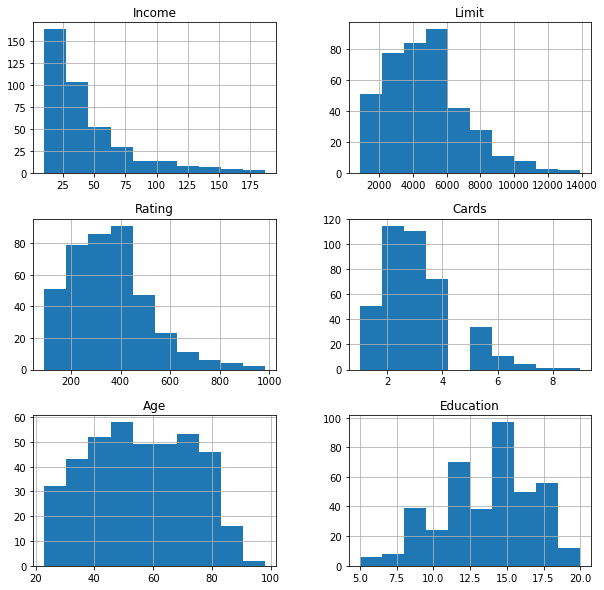

In [11]:
ax = X.hist(figsize=(10, 10))


Note that we are seeing the historgrams for only 6 variables. Note that the remaning four features, i.e. "Gender",	"Student", "Married", and	"Ethnicity", are all categorical. The first three variables are binary variables. "Ethnicity", however, can have more than two categories.

In [31]:
def get_categorical_features(df):
    """
    Returns the name of the categorical features of the input dataframe `df`
    
    Parameter
    ---------
    df: DataFrame
        a dataframe
    
    Returns
    -------
    categorical_features: list
        the name of categorical features
    """
    all_features_set = set(df.columns)
    numerical_features_set = set(df.select_dtypes(include=[np.number]).columns)
    categorical_features = all_features_set - numerical_features_set
    
    return list(categorical_features)

In [32]:
# get cat features
cat_features = get_categorical_features(X)
cat_features

['Student', 'Ethnicity', 'Gender', 'Married']

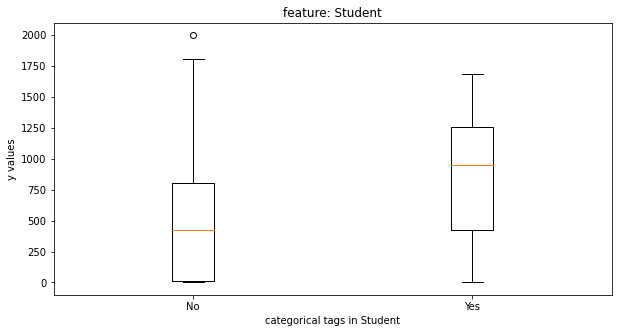

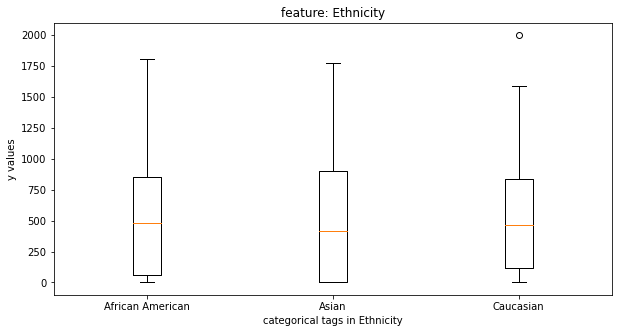

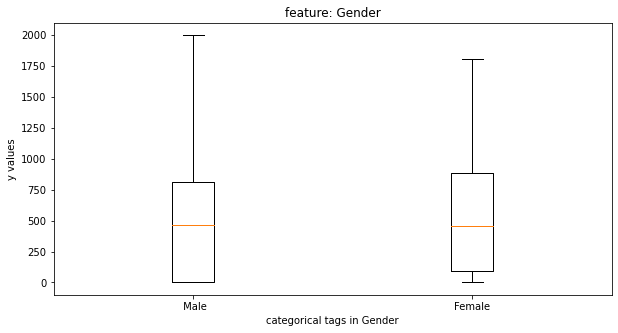

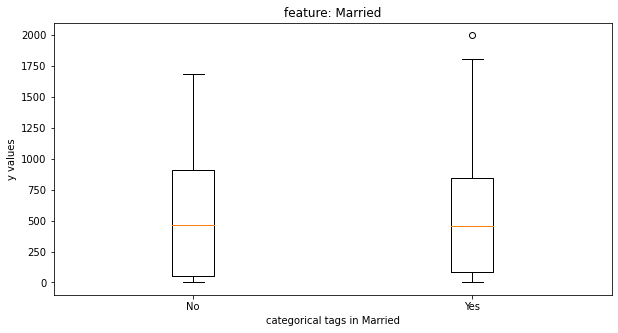

In [48]:
for feature in cat_features:
    
    plt.figure(figsize=(10, 5))
    for i, (tag, y_of_tag) in enumerate(y.groupby(by=X[feature])): 
        plt.boxplot(y_of_tag, positions=[i], labels=[tag])
    
    plt.title(f'feature: {feature}')
    plt.xlabel(f'categorical tags in {feature}')
    plt.ylabel('y values')
    plt.show()

It seems that the categorical feature "Student" has more relationship (impact) on the y value.

Note that we can also plot the y against each of the numericl feature and see what information we can get from them. (Feel free to do it as exercise). 

Now, we want to perform exhuastive search (brute-force). But, befor that, we just need to perform some data preprocessing. Let's start with finding missing data.

In [49]:
X.isnull().sum(axis=0)

Income       0
Limit        0
Rating       0
Cards        0
Age          0
Education    0
Gender       0
Student      0
Married      0
Ethnicity    0
dtype: int64

Cool! There is no missing value. We can also search for outliers. But, for now, we are okay. Next step is to convert categorical features to numerical features. 

In [52]:
X_new = X.copy()

for feature in cat_features:
    n_tags = len(set(X[feature]))
    if n_tags == 1:
        X_new.drop(columns=[feature], inplace=True)
    elif n_tags == 2:
        le = LabelEncoder()
        le.fit(X[feature])
        X_new[feature] = le.transform(X[feature])

X_new.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity
1,14.891,3606,283,2,34,11,0,0,1,Caucasian
2,106.025,6645,483,3,82,15,1,1,1,Asian
3,104.593,7075,514,4,71,11,0,0,0,Asian
4,148.924,9504,681,3,36,11,1,0,0,Asian
5,55.882,4897,357,2,68,16,0,0,1,Caucasian


The last column has three tags (shown in one of the previous boxplots). So, what can we do?
* Maybe we replace each tag, with the mean (or median) of its corresponding y values. So, we basically convert this column to a new column where each tag is replaced with the mean (or median) of its corresponding y value. (I think this approach is called `target mean`)
* We can do one-hot-encoding and convert this column into three new columns. 

In this notebook, I will go with the latter. Note that when we transform the last column into three columns, we have now more features. One might be interested in considering each of these new feature on its own. So, we will have 12 features in this case. However, one might also assume that these new columns are all related to the feature `Ethinity`, and they may want to consider them together. 

Fig. 6.1 of the book shows 11 as the number of features. So, I assume the authors of the book took the former approach in which they consider each of the new feature on its own. But, why 11 features? Because, they probably `drop` one of the encoded features. Let's do it :)

In [58]:
feature = "Ethnicity"
ct = ColumnTransformer(
        transformers=[('ohe', OneHotEncoder(drop='first'), [feature])], 
        remainder='drop'
        )

ct.fit(X_new)
feature_transformed = ct.transform(X_new)

feature_transformed

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

But, before attaching this to `X_new`, we can figure out what tag is transformed to what!

In [68]:
ohe_fitted = ct.named_transformers_['ohe']
ohe_fitted.get_feature_names_out()

array(['Ethnicity_Asian', 'Ethnicity_Caucasian'], dtype=object)

So, the encoder dropped the tag "African American". The two remaining tags are transformed to two new features. 

So, let us append `feature_transformed` to `X_new`:

In [72]:
X_transformed = X_new.copy()
X_transformed[ohe_fitted.get_feature_names_out()] = feature_transformed
X_transformed.drop(columns=["Ethnicity"], inplace=True)

X_transformed.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity_Asian,Ethnicity_Caucasian
1,14.891,3606,283,2,34,11,0,0,1,0.0,1.0
2,106.025,6645,483,3,82,15,1,1,1,1.0,0.0
3,104.593,7075,514,4,71,11,0,0,0,1.0,0.0
4,148.924,9504,681,3,36,11,1,0,0,1.0,0.0
5,55.882,4897,357,2,68,16,0,0,1,0.0,1.0


Now, we are ready to perform our brute-force feature selection :) Let's go!

(**Note:** we can split it into train/test, but for now, we are going to use the whole data. Also, you may want to normalize each feature. This is not important in regression. But, since we usually do standardization, we prefer to do it here as well)

In [95]:
finalized_features = list(X_transformed.columns)
finalized_features

['Income',
 'Limit',
 'Rating',
 'Cards',
 'Age',
 'Education',
 'Gender',
 'Student',
 'Married',
 'Ethnicity_Asian',
 'Ethnicity_Caucasian']

In [76]:
n_features = len(X_transformed.columns)

sc = StandardScaler()
sc.fit(X_transformed)
X_preprocess = sc.transform(X_transformed)

In [83]:
exhuastive_feature_selection = {i:{'r2_scores':[], 'features':[]} for i in range(1, n_features + 1)}
exhuastive_feature_selection    

{1: {'r2_scores': [], 'features': []},
 2: {'r2_scores': [], 'features': []},
 3: {'r2_scores': [], 'features': []},
 4: {'r2_scores': [], 'features': []},
 5: {'r2_scores': [], 'features': []},
 6: {'r2_scores': [], 'features': []},
 7: {'r2_scores': [], 'features': []},
 8: {'r2_scores': [], 'features': []},
 9: {'r2_scores': [], 'features': []},
 10: {'r2_scores': [], 'features': []},
 11: {'r2_scores': [], 'features': []}}

In [85]:
indices = np.arange(n_features)

print(f'starting brute-force on {n_features} features')
print('----------------------------------------------')
for i in range(1, n_features + 1):
    for IDX in combinations(indices, i):
        print(f'# features selected: {i} --> selected-features indices: {IDX}')
        
        X_sel = X_preprocess[:, IDX]
        reg = LinearRegression().fit(X_sel, y)
        r2 = r2_score(y, reg.predict(X_sel))
        
        exhuastive_feature_selection[i]["r2_scores"].append(r2)
        exhuastive_feature_selection[i]["features"].append(IDX)

starting brute-force on 11 features
----------------------------------------------
# features selected: 1 --> selected-features indices: (0,)
# features selected: 1 --> selected-features indices: (1,)
# features selected: 1 --> selected-features indices: (2,)
# features selected: 1 --> selected-features indices: (3,)
# features selected: 1 --> selected-features indices: (4,)
# features selected: 1 --> selected-features indices: (5,)
# features selected: 1 --> selected-features indices: (6,)
# features selected: 1 --> selected-features indices: (7,)
# features selected: 1 --> selected-features indices: (8,)
# features selected: 1 --> selected-features indices: (9,)
# features selected: 1 --> selected-features indices: (10,)
# features selected: 2 --> selected-features indices: (0, 1)
# features selected: 2 --> selected-features indices: (0, 2)
# features selected: 2 --> selected-features indices: (0, 3)
# features selected: 2 --> selected-features indices: (0, 4)
# features selected: 2 

# features selected: 3 --> selected-features indices: (2, 6, 9)
# features selected: 3 --> selected-features indices: (2, 6, 10)
# features selected: 3 --> selected-features indices: (2, 7, 8)
# features selected: 3 --> selected-features indices: (2, 7, 9)
# features selected: 3 --> selected-features indices: (2, 7, 10)
# features selected: 3 --> selected-features indices: (2, 8, 9)
# features selected: 3 --> selected-features indices: (2, 8, 10)
# features selected: 3 --> selected-features indices: (2, 9, 10)
# features selected: 3 --> selected-features indices: (3, 4, 5)
# features selected: 3 --> selected-features indices: (3, 4, 6)
# features selected: 3 --> selected-features indices: (3, 4, 7)
# features selected: 3 --> selected-features indices: (3, 4, 8)
# features selected: 3 --> selected-features indices: (3, 4, 9)
# features selected: 3 --> selected-features indices: (3, 4, 10)
# features selected: 3 --> selected-features indices: (3, 5, 6)
# features selected: 3 --> selected

# features selected: 4 --> selected-features indices: (0, 6, 8, 10)
# features selected: 4 --> selected-features indices: (0, 6, 9, 10)
# features selected: 4 --> selected-features indices: (0, 7, 8, 9)
# features selected: 4 --> selected-features indices: (0, 7, 8, 10)
# features selected: 4 --> selected-features indices: (0, 7, 9, 10)
# features selected: 4 --> selected-features indices: (0, 8, 9, 10)
# features selected: 4 --> selected-features indices: (1, 2, 3, 4)
# features selected: 4 --> selected-features indices: (1, 2, 3, 5)
# features selected: 4 --> selected-features indices: (1, 2, 3, 6)
# features selected: 4 --> selected-features indices: (1, 2, 3, 7)
# features selected: 4 --> selected-features indices: (1, 2, 3, 8)
# features selected: 4 --> selected-features indices: (1, 2, 3, 9)
# features selected: 4 --> selected-features indices: (1, 2, 3, 10)
# features selected: 4 --> selected-features indices: (1, 2, 4, 5)
# features selected: 4 --> selected-features indices: (1

# features selected: 4 --> selected-features indices: (4, 5, 7, 9)
# features selected: 4 --> selected-features indices: (4, 5, 7, 10)
# features selected: 4 --> selected-features indices: (4, 5, 8, 9)
# features selected: 4 --> selected-features indices: (4, 5, 8, 10)
# features selected: 4 --> selected-features indices: (4, 5, 9, 10)
# features selected: 4 --> selected-features indices: (4, 6, 7, 8)
# features selected: 4 --> selected-features indices: (4, 6, 7, 9)
# features selected: 4 --> selected-features indices: (4, 6, 7, 10)
# features selected: 4 --> selected-features indices: (4, 6, 8, 9)
# features selected: 4 --> selected-features indices: (4, 6, 8, 10)
# features selected: 4 --> selected-features indices: (4, 6, 9, 10)
# features selected: 4 --> selected-features indices: (4, 7, 8, 9)
# features selected: 4 --> selected-features indices: (4, 7, 8, 10)
# features selected: 4 --> selected-features indices: (4, 7, 9, 10)
# features selected: 4 --> selected-features indices: 

# features selected: 5 --> selected-features indices: (0, 2, 4, 9, 10)
# features selected: 5 --> selected-features indices: (0, 2, 5, 6, 7)
# features selected: 5 --> selected-features indices: (0, 2, 5, 6, 8)
# features selected: 5 --> selected-features indices: (0, 2, 5, 6, 9)
# features selected: 5 --> selected-features indices: (0, 2, 5, 6, 10)
# features selected: 5 --> selected-features indices: (0, 2, 5, 7, 8)
# features selected: 5 --> selected-features indices: (0, 2, 5, 7, 9)
# features selected: 5 --> selected-features indices: (0, 2, 5, 7, 10)
# features selected: 5 --> selected-features indices: (0, 2, 5, 8, 9)
# features selected: 5 --> selected-features indices: (0, 2, 5, 8, 10)
# features selected: 5 --> selected-features indices: (0, 2, 5, 9, 10)
# features selected: 5 --> selected-features indices: (0, 2, 6, 7, 8)
# features selected: 5 --> selected-features indices: (0, 2, 6, 7, 9)
# features selected: 5 --> selected-features indices: (0, 2, 6, 7, 10)
# features sel

# features selected: 5 --> selected-features indices: (1, 3, 5, 8, 9)
# features selected: 5 --> selected-features indices: (1, 3, 5, 8, 10)
# features selected: 5 --> selected-features indices: (1, 3, 5, 9, 10)
# features selected: 5 --> selected-features indices: (1, 3, 6, 7, 8)
# features selected: 5 --> selected-features indices: (1, 3, 6, 7, 9)
# features selected: 5 --> selected-features indices: (1, 3, 6, 7, 10)
# features selected: 5 --> selected-features indices: (1, 3, 6, 8, 9)
# features selected: 5 --> selected-features indices: (1, 3, 6, 8, 10)
# features selected: 5 --> selected-features indices: (1, 3, 6, 9, 10)
# features selected: 5 --> selected-features indices: (1, 3, 7, 8, 9)
# features selected: 5 --> selected-features indices: (1, 3, 7, 8, 10)
# features selected: 5 --> selected-features indices: (1, 3, 7, 9, 10)
# features selected: 5 --> selected-features indices: (1, 3, 8, 9, 10)
# features selected: 5 --> selected-features indices: (1, 4, 5, 6, 7)
# features s

# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 4, 9)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 4, 10)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 5, 6)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 5, 7)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 5, 8)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 5, 9)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 5, 10)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 6, 7)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 6, 8)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 6, 9)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 6, 10)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 7, 8)
# features selected: 6 --> selected-features indices: (0, 1, 2, 3, 7, 9)
# features selected: 6 --> selected-features ind

# features selected: 6 --> selected-features indices: (0, 2, 5, 6, 7, 8)
# features selected: 6 --> selected-features indices: (0, 2, 5, 6, 7, 9)
# features selected: 6 --> selected-features indices: (0, 2, 5, 6, 7, 10)
# features selected: 6 --> selected-features indices: (0, 2, 5, 6, 8, 9)
# features selected: 6 --> selected-features indices: (0, 2, 5, 6, 8, 10)
# features selected: 6 --> selected-features indices: (0, 2, 5, 6, 9, 10)
# features selected: 6 --> selected-features indices: (0, 2, 5, 7, 8, 9)
# features selected: 6 --> selected-features indices: (0, 2, 5, 7, 8, 10)
# features selected: 6 --> selected-features indices: (0, 2, 5, 7, 9, 10)
# features selected: 6 --> selected-features indices: (0, 2, 5, 8, 9, 10)
# features selected: 6 --> selected-features indices: (0, 2, 6, 7, 8, 9)
# features selected: 6 --> selected-features indices: (0, 2, 6, 7, 8, 10)
# features selected: 6 --> selected-features indices: (0, 2, 6, 7, 9, 10)
# features selected: 6 --> selected-feature

# features selected: 6 --> selected-features indices: (1, 3, 4, 6, 7, 10)
# features selected: 6 --> selected-features indices: (1, 3, 4, 6, 8, 9)
# features selected: 6 --> selected-features indices: (1, 3, 4, 6, 8, 10)
# features selected: 6 --> selected-features indices: (1, 3, 4, 6, 9, 10)
# features selected: 6 --> selected-features indices: (1, 3, 4, 7, 8, 9)
# features selected: 6 --> selected-features indices: (1, 3, 4, 7, 8, 10)
# features selected: 6 --> selected-features indices: (1, 3, 4, 7, 9, 10)
# features selected: 6 --> selected-features indices: (1, 3, 4, 8, 9, 10)
# features selected: 6 --> selected-features indices: (1, 3, 5, 6, 7, 8)
# features selected: 6 --> selected-features indices: (1, 3, 5, 6, 7, 9)
# features selected: 6 --> selected-features indices: (1, 3, 5, 6, 7, 10)
# features selected: 6 --> selected-features indices: (1, 3, 5, 6, 8, 9)
# features selected: 6 --> selected-features indices: (1, 3, 5, 6, 8, 10)
# features selected: 6 --> selected-feature

# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 6, 7)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 6, 8)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 6, 9)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 6, 10)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 7, 8)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 7, 9)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 7, 10)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 8, 9)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 8, 10)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 5, 9, 10)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 6, 7, 8)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 6, 7, 9)
# features selected: 7 --> selected-features indices: (0, 1, 2, 3, 6, 7, 10)
# featu

# features selected: 7 --> selected-features indices: (0, 2, 3, 4, 8, 9, 10)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 6, 7, 8)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 6, 7, 9)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 6, 7, 10)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 6, 8, 9)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 6, 8, 10)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 6, 9, 10)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 7, 8, 9)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 7, 8, 10)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 7, 9, 10)
# features selected: 7 --> selected-features indices: (0, 2, 3, 5, 8, 9, 10)
# features selected: 7 --> selected-features indices: (0, 2, 3, 6, 7, 8, 9)
# features selected: 7 --> selected-features indices: (0, 2, 3, 6, 7, 8, 10)
# fe

# features selected: 7 --> selected-features indices: (1, 3, 5, 7, 8, 9, 10)
# features selected: 7 --> selected-features indices: (1, 3, 6, 7, 8, 9, 10)
# features selected: 7 --> selected-features indices: (1, 4, 5, 6, 7, 8, 9)
# features selected: 7 --> selected-features indices: (1, 4, 5, 6, 7, 8, 10)
# features selected: 7 --> selected-features indices: (1, 4, 5, 6, 7, 9, 10)
# features selected: 7 --> selected-features indices: (1, 4, 5, 6, 8, 9, 10)
# features selected: 7 --> selected-features indices: (1, 4, 5, 7, 8, 9, 10)
# features selected: 7 --> selected-features indices: (1, 4, 6, 7, 8, 9, 10)
# features selected: 7 --> selected-features indices: (1, 5, 6, 7, 8, 9, 10)
# features selected: 7 --> selected-features indices: (2, 3, 4, 5, 6, 7, 8)
# features selected: 7 --> selected-features indices: (2, 3, 4, 5, 6, 7, 9)
# features selected: 7 --> selected-features indices: (2, 3, 4, 5, 6, 7, 10)
# features selected: 7 --> selected-features indices: (2, 3, 4, 5, 6, 8, 9)
# f

# features selected: 8 --> selected-features indices: (0, 2, 3, 5, 7, 8, 9, 10)
# features selected: 8 --> selected-features indices: (0, 2, 3, 6, 7, 8, 9, 10)
# features selected: 8 --> selected-features indices: (0, 2, 4, 5, 6, 7, 8, 9)
# features selected: 8 --> selected-features indices: (0, 2, 4, 5, 6, 7, 8, 10)
# features selected: 8 --> selected-features indices: (0, 2, 4, 5, 6, 7, 9, 10)
# features selected: 8 --> selected-features indices: (0, 2, 4, 5, 6, 8, 9, 10)
# features selected: 8 --> selected-features indices: (0, 2, 4, 5, 7, 8, 9, 10)
# features selected: 8 --> selected-features indices: (0, 2, 4, 6, 7, 8, 9, 10)
# features selected: 8 --> selected-features indices: (0, 2, 5, 6, 7, 8, 9, 10)
# features selected: 8 --> selected-features indices: (0, 3, 4, 5, 6, 7, 8, 9)
# features selected: 8 --> selected-features indices: (0, 3, 4, 5, 6, 7, 8, 10)
# features selected: 8 --> selected-features indices: (0, 3, 4, 5, 6, 7, 9, 10)
# features selected: 8 --> selected-featur

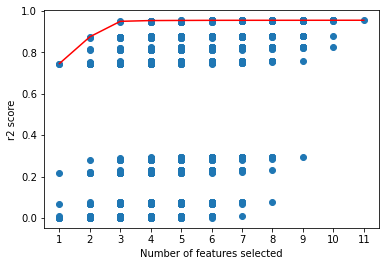

In [96]:
# now, let us plot it!
x_r2 = []
y_r2 = []

r2_max_per_n = []
best_features_selected_per_n = []

for key, item in exhuastive_feature_selection.items(): 
    # note that item itself is dictionary here!
    r2_scores = item['r2_scores']
    
    x_r2.extend([key]*len(r2_scores))
    y_r2.extend(r2_scores)
    
    idx = np.argmax(r2_scores)
    r2_max_per_n.append(r2_scores[idx])
    best_features_selected_per_n.append(item["features"][idx])

plt.scatter(x_r2, y_r2)
plt.plot(np.arange(1, n_features + 1), r2_max_per_n, c='r')
plt.xticks(ticks=np.arange(1, n_features + 1), labels=np.arange(1, n_features + 1))
plt.xlabel('Number of features selected')
plt.ylabel('r2 score')
plt.show()

Very Cool! Now, before moving forward, let us first find the best model for each number of features and show the selected features from it!

In [97]:
best_features_selected_per_n

[(2,),
 (0, 2),
 (0, 2, 7),
 (0, 1, 3, 7),
 (0, 1, 2, 3, 7),
 (0, 1, 2, 3, 4, 7),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 6, 7, 9),
 (0, 1, 2, 3, 4, 6, 7, 8, 9),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 10),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)]

Great! Now, we should consider each of these set of features and evaluate them with help of `adjusted r2_score` (or AIC / BIC). We evaluate each set with cross-validation.

In [115]:
def adjusted_r2(r2_score, n, p):
    """
    Calculate adjusted_r2_score
    
    Parameters
    ----------
    r2_score: float
        r2_squared score
    
    n: number of observations
    p: number of features
    
    Returns
    -------
    out: float
        adjusted r2_score
    """
    return 1 - ((1 - r2_score) * (n - 1) / (n - p - 1))

In [116]:
n_samples = X_preprocess.shape[0]
cv = 10 # number of folds

n_samples_test = n_samples // cv # fortunately, n_samples is 400, which is dividable by cv=10. 
# Otherwise, we first need to know how sklearn split samples when it is not exactly dividable by cv. 
n_samples_train = n_samples - n_samples_test


test_scores = []
train_scores = []
for selected_features in best_features_selected_per_n:
    n_feature = len(selected_features)
    
    X_sel = X_preprocess[:, selected_features]
    cv_results = cross_validate(LinearRegression(), X_sel, y, scoring="r2", cv=cv, return_train_score=True)
    
    
    r2 = np.mean(cv_results["test_score"])
    adj_r2_score = adjusted_r2(r2, n_samples_test, n_feature)
    test_scores.append(adj_r2_score)
    
    r2 = np.mean(cv_results["train_score"])
    adj_r2_score = adjusted_r2(r2, n_samples_train, n_feature)
    train_scores.append(adj_r2_score)

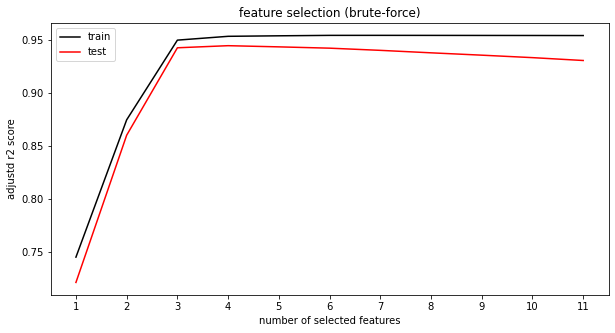

In [124]:
n_feature = X_preprocess.shape[1]

plt.figure(figsize=(10, 5))

plt.plot(train_scores, c='k', label='train')
plt.plot(test_scores, c='r', label='test')
plt.title("feature selection (brute-force)")
plt.xlabel("number of selected features")
plt.ylabel('adjustd r2 score')

plt.xticks(np.arange(n_feature), labels=np.arange(1, n_feature + 1))
plt.legend()
plt.show()

it seems we have the highest score in 3 / 4 features. What are those features?

In [125]:
# python 0 indexing

# 3 features
selected_features = best_features_selected_per_n[2]
print("for three features: ", [finalized_features[x] for x in selected_features])


# 4 features
selected_features = best_features_selected_per_n[3]
print("for four features: ", [finalized_features[x] for x in selected_features])

for three features:  ['Income', 'Rating', 'Student']
for four features:  ['Income', 'Limit', 'Cards', 'Student']


AWESOME! 